In [24]:
import numpy as np
import pandas as pd
import shap
import optuna
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('../data/engineered_grit_data.csv')
df.head()

,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL7,VCL8,VCL10,VCL11,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,340,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,126,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,130,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1
3,592,1,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,217,1,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [ ]:

X = df[['C8', 'C9', 'C1', 'C10', 'C5', 'C4', 'N7', 'C3', 'A10', 'C2', 'N5', 'A8', 'O2', 'E10', 'age_group_18-30']]
y = df['Grit']

X.shape

In [ ]:
# Load data
df = pd.read_csv('../data/engineered_grit_data.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Define features and target
X = df[['C8', 'C9', 'C1', 'C10', 'C5', 'C4', 'N7', 'C3', 'A10', 'C2', 'N5', 'A8', 'O2', 'E10', 'age_group_18-30']]
y_continuous = df['Grit']


In [ ]:
# Bin Grit scores into three classes (1-5 scale)
# Low: 1.0-2.33, Medium: 2.34-3.66, High: 3.67-5.0
def bin_grit(score):
    if score <= 2.33:
        return 0  # Low
    elif score <= 3.66:
        return 1  # Medium
    else:
        return 2  # High

y = y_continuous.apply(bin_grit)

print(f"\nFeatures shape: {X.shape}")
print(f"\nClass distribution:")
print(y.value_counts().sort_index())
print(f"\nClass proportions:")
print(y.value_counts(normalize=True).sort_index())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTrain class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest class distribution:\n{y_test.value_counts().sort_index()}")


In [ ]:
#Ill try baseline lightgbm model first, then random search, then optuna. I wanted to try grid search but that took too long. 

In [ ]:
# ===========================
# 1. BASELINE MODEL
# ===========================
print("\n" + "="*60)
print("1. BASELINE LIGHTGBM MODEL")
print("="*60)

baseline_model = LGBMClassifier(
    random_state=42,
    verbose=-1
)

baseline_model.fit(X_train, y_train)

y_pred_train = baseline_model.predict(X_train)
y_pred_test = baseline_model.predict(X_test)

print("\nBaseline Model Performance:")
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"F1-Score (weighted): {f1_score(y_train, y_pred_train, average='weighted'):.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_test, average='weighted'):.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=['Low', 'Medium', 'High']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Baseline Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Dataset shape: (2200, 96)

First few rows:
   surveyelapse  VCL1  VCL2  VCL3  VCL4  VCL5  VCL7  VCL8  VCL10  VCL11  ...  \
0           340     0     0     0     1     0     0     0      1      0  ...   
1           126     1     1     1     1     1     1     1      1      1  ...   
2           130     1     1     1     1     1     0     1      1      1  ...   
3           592     1     0     0     1     1     0     0      1      0  ...   
4           217     1     1     0     0     1     0     0      1      0  ...   

   operatingsystem_ChromeOS  operatingsystem_Linux  operatingsystem_Macintosh  \
0                         0                      0                          0   
1                         0                      0                          0   
2                         0                      0                          0   
3                         0                      0                          0   
4                         0                      0                     

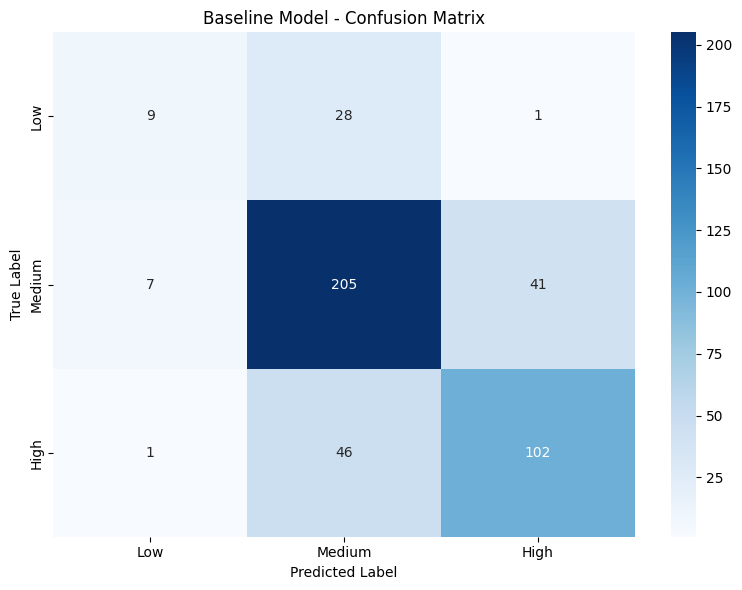


2. RANDOMIZED SEARCH HYPERPARAMETER TUNING
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=15, min_child_samples=50, min_split_gain=0.2, n_estimators=300, num_leaves=31, reg_alpha=0.01, reg_lambda=1.0, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=15, min_child_samples=50, min_split_gain=0.2, n_estimators=300, num_leaves=31, reg_alpha=0.01, reg_lambda=1.0, subsample=0.6; total time=   3.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=15, min_child_samples=50, min_split_gain=0.2, n_estimators=300, num_leaves=31, reg_alpha=0.01, reg_lambda=1.0, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=5, min_child_samples=20, min_split_gain=0.1, n_estimators=200, num_leaves=15, reg_alpha=0.01, reg_lambda=1.0, subsample=0.9; total time=   4.4s
[CV] END colsample_bytree=0.6, learning_rate=0.03, max_depth=5, min_ch

In [ ]:
# ===========================
# 2. RANDOMIZED SEARCH
# ===========================
print("\n" + "="*60)
print("2. RANDOMIZED SEARCH HYPERPARAMETER TUNING")
print("="*60)

param_dist = {
    'n_estimators': [100, 200, 300, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10, 15],
    'num_leaves': [15, 31, 63, 127],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0, 0.01, 0.1, 1.0],
    'min_split_gain': [0.0, 0.1, 0.2]
}

random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42, verbose=-1),
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\nBest parameters (Random Search):", random_search.best_params_)
print("Best CV F1-Score:", random_search.best_score_)

random_model = random_search.best_estimator_

y_pred_train = random_model.predict(X_train)
y_pred_test = random_model.predict(X_test)

print("\nRandomized Search Model Performance:")
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"F1-Score (weighted): {f1_score(y_train, y_pred_train, average='weighted'):.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_test, average='weighted'):.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=['Low', 'Medium', 'High']))



In [ ]:
# ===========================
# 3. GRID SEARCH
# ===========================
print("\n" + "="*60)
print("3. GRID SEARCH HYPERPARAMETER TUNING")
print("="*60)

# Refined grid based on random search results
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 7, 10],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 30],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42, verbose=-1),
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters (Grid Search):", grid_search.best_params_)
print("Best CV F1-Score:", grid_search.best_score_)

grid_model = grid_search.best_estimator_

y_pred_train = grid_model.predict(X_train)
y_pred_test = grid_model.predict(X_test)

print("\nGrid Search Model Performance:")
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"F1-Score (weighted): {f1_score(y_train, y_pred_train, average='weighted'):.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_test, average='weighted'):.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=['Low', 'Medium', 'High']))

[I 2025-11-30 22:14:17,304] A new study created in memory with name: no-name-12c50cad-7b01-4035-b505-59e0f3413c6e



4. OPTUNA HYPERPARAMETER OPTIMIZATION (FAST)


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-30 22:14:21,921] Trial 0 finished with value: 0.6689565109866656 and parameters: {'n_estimators': 132, 'learning_rate': 0.12296079973724361, 'max_depth': 6, 'num_leaves': 49, 'min_child_samples': 10, 'subsample': 0.8216571069961629, 'colsample_bytree': 0.8616405936953538, 'reg_alpha': 2.44971862419588e-07, 'reg_lambda': 1.4899891862166468e-05, 'min_split_gain': 0.008088564388119368}. Best is trial 0 with value: 0.6689565109866656.
[I 2025-11-30 22:14:23,144] Trial 1 finished with value: 0.6866879731930898 and parameters: {'n_estimators': 394, 'learning_rate': 0.16130283948647278, 'max_depth': 4, 'num_leaves': 39, 'min_child_samples': 28, 'subsample': 0.6757836079865525, 'colsample_bytree': 0.9888886399785402, 'reg_alpha': 1.7306462262149932e-08, 'reg_lambda': 0.0027965366670524867, 'min_split_gain': 0.14011831037896494}. Best is trial 1 with value: 0.6866879731930898.
[I 2025-11-30 22:14:25,069] Trial 2 finished with value: 0.6863763235080252 and parameters: {'n_estimators':

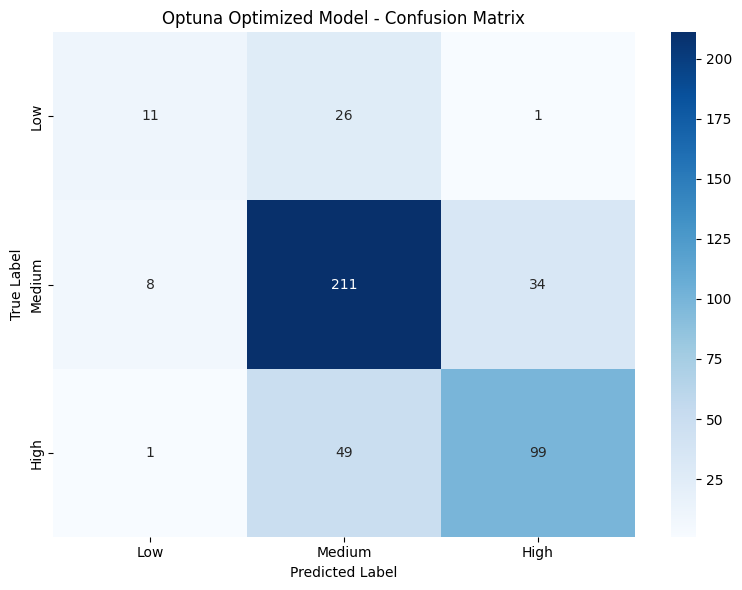

In [4]:
# ===========================
# 4. OPTUNA OPTIMIZATION
# ===========================
print("\n" + "="*60)
print("4. OPTUNA HYPERPARAMETER OPTIMIZATION (FAST)")
print("="*60)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Reduced range
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Reduced range
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),  # Reduced range
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),  # Reduced range
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # Reduced range
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # Reduced range
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.3),
        'random_state': 42,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    
    # Use 3-fold CV instead of 5 to speed up
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=3,  # Changed from 5 to 3
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    return cv_scores.mean()

study = optuna.create_study(direction='maximize')
# Reduced from 50 to 30 trials
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\nBest Trial (Optuna):")
print(study.best_trial.params)
print("Best CV F1-Score:", study.best_value)

optuna_params = study.best_trial.params
optuna_model = LGBMClassifier(**optuna_params)
optuna_model.fit(X_train, y_train)

y_pred_train = optuna_model.predict(X_train)
y_pred_test = optuna_model.predict(X_test)

print("\nOptuna Model Performance:")
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"F1-Score (weighted): {f1_score(y_train, y_pred_train, average='weighted'):.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_test, average='weighted'):.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=['Low', 'Medium', 'High']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Optuna Optimized Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()




5. MODEL COMPARISON SUMMARY

         Model  Accuracy  F1-Score  Precision   Recall
     Baseline  0.718182  0.707178   0.708080 0.718182
Random Search  0.727273  0.715481   0.720983 0.727273
       Optuna  0.729545  0.719870   0.721900 0.729545

🏆 Best Model: Optuna
Best F1-Score: 0.7199


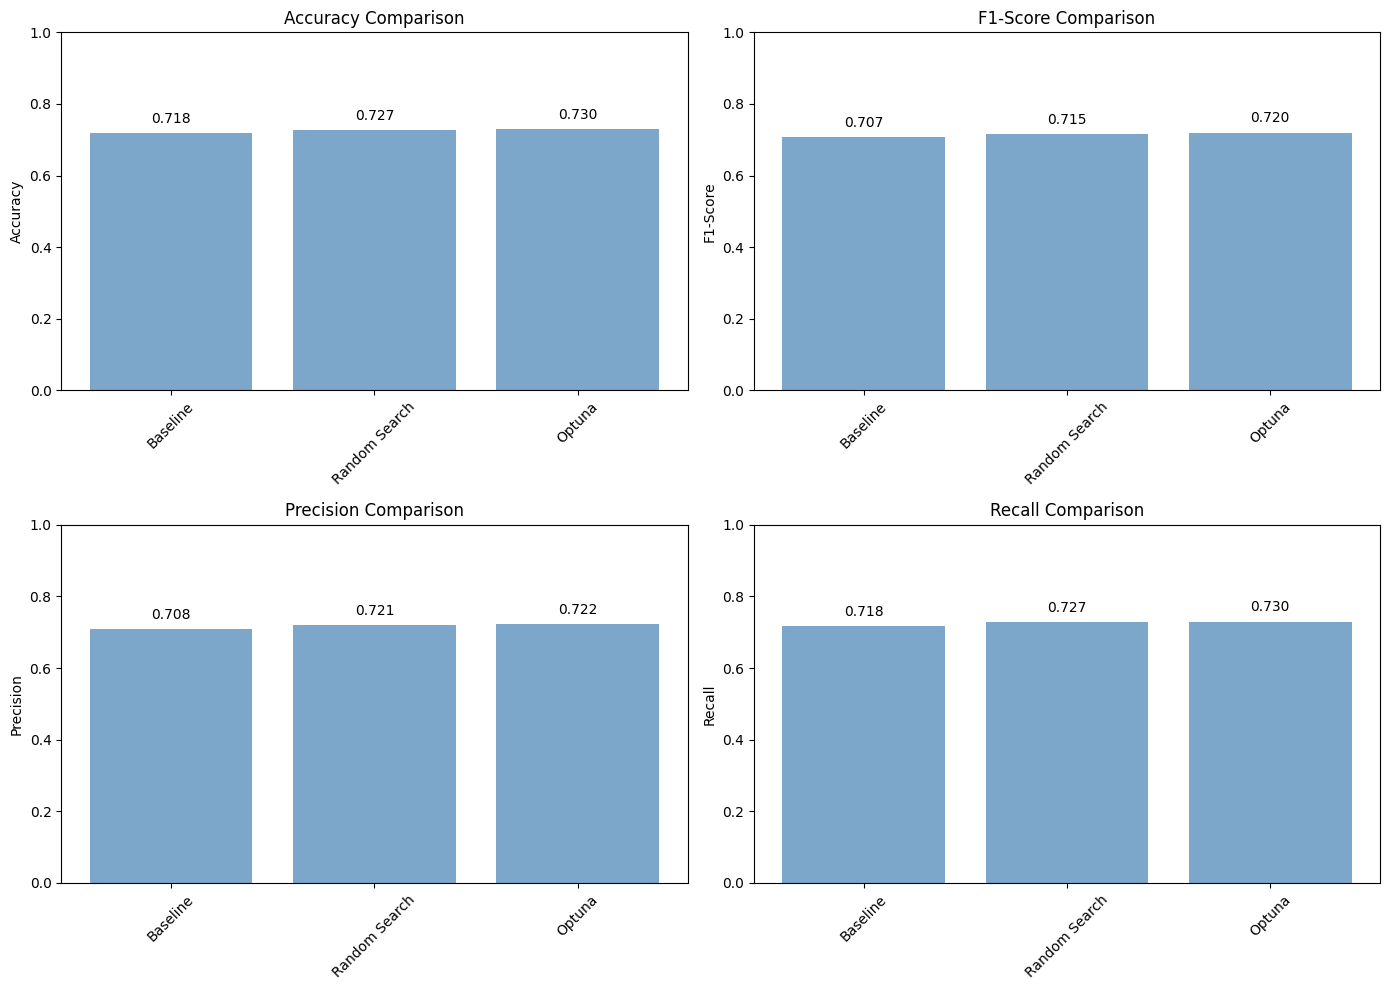

In [6]:
# ===========================
# 5. MODEL COMPARISON
# ===========================
print("\n" + "="*60)
print("5. MODEL COMPARISON SUMMARY")
print("="*60)

models = {
    'Baseline': baseline_model,
    'Random Search': random_model,
    #'Grid Search': grid_model,
    'Optuna': optuna_model
}

comparison_results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    results = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    }
    comparison_results.append(results)

comparison_df = pd.DataFrame(comparison_results)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Best F1-Score: {comparison_df['F1-Score'].max():.4f}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(comparison_df['Model'], comparison_df[metric], color='steelblue', alpha=0.7)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
#it seems there is a performance ceiling around 73 %. ill now try ensembling methods with xg boost to see if that helps.

In [9]:

# ===========================
# 1. OPTIMIZE LIGHTGBM
# ===========================
print("\n" + "="*70)
print("STEP 1: Optimizing LightGBM with Optuna")
print("="*70)

def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'verbose': -1,
        'class_weight': 'balanced'  # Handle class imbalance
    }
    
    model = LGBMClassifier(**params)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, 
                                scoring='f1_weighted', n_jobs=-1)
    return cv_scores.mean()

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=30, show_progress_bar=True)

print(f"\n✅ Best LightGBM F1-Score: {lgbm_study.best_value:.4f}")
print(f"📋 Best parameters: {lgbm_study.best_trial.params}")

lgbm_best = LGBMClassifier(**lgbm_study.best_trial.params)
lgbm_best.fit(X_train, y_train)

[I 2025-11-30 22:35:11,190] A new study created in memory with name: no-name-90710784-8de0-4c90-9064-cef66645c3d7



STEP 1: Optimizing LightGBM with Optuna


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-30 22:35:14,967] Trial 0 finished with value: 0.663368793958934 and parameters: {'n_estimators': 122, 'learning_rate': 0.07758290805334005, 'max_depth': 5, 'num_leaves': 66, 'min_child_samples': 31, 'subsample': 0.8043775405711853, 'colsample_bytree': 0.9305366249890655, 'reg_alpha': 0.011384698631626918, 'reg_lambda': 2.68644410867941e-05}. Best is trial 0 with value: 0.663368793958934.
[I 2025-11-30 22:35:16,745] Trial 1 finished with value: 0.6608433605018943 and parameters: {'n_estimators': 319, 'learning_rate': 0.1465949562371147, 'max_depth': 4, 'num_leaves': 64, 'min_child_samples': 27, 'subsample': 0.9223813518885633, 'colsample_bytree': 0.7796379349203778, 'reg_alpha': 0.31958969581402824, 'reg_lambda': 0.01930445740236598}. Best is trial 0 with value: 0.663368793958934.
[I 2025-11-30 22:35:19,699] Trial 2 finished with value: 0.6676427364626094 and parameters: {'n_estimators': 251, 'learning_rate': 0.12736030903195417, 'max_depth': 5, 'num_leaves': 103, 'min_child_

,boosting_type,'gbdt'
,num_leaves,90
,max_depth,10
,learning_rate,0.025578999218531413
,n_estimators,284
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,21


In [13]:
# ===========================
# 2. OPTIMIZE XGBOOST
# ===========================
from xgboost import XGBClassifier

print("\n" + "="*70)
print("STEP 2: Optimizing XGBoost with Optuna")
print("="*70)

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'verbosity': 0,
        'eval_metric': 'mlogloss'
    }
    
    model = XGBClassifier(**params)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, 
                                scoring='f1_weighted', n_jobs=-1)
    return cv_scores.mean()

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=30, show_progress_bar=True)

print(f"\n✅ Best XGBoost F1-Score: {xgb_study.best_value:.4f}")
print(f"📋 Best parameters: {xgb_study.best_trial.params}")

xgb_best = XGBClassifier(**xgb_study.best_trial.params)
xgb_best.fit(X_train, y_train)


[I 2025-11-30 22:53:31,277] A new study created in memory with name: no-name-c5db083d-ead3-42d2-a71a-7e614dd7c077



STEP 2: Optimizing XGBoost with Optuna


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-30 22:53:34,203] Trial 0 finished with value: 0.6685513450059882 and parameters: {'n_estimators': 389, 'learning_rate': 0.12784907304418874, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9329451474912477, 'colsample_bytree': 0.8125991235447179, 'gamma': 0.0069360715112727345, 'reg_alpha': 0.9653951566568622, 'reg_lambda': 0.00954673770268415}. Best is trial 0 with value: 0.6685513450059882.
[I 2025-11-30 22:53:35,243] Trial 1 finished with value: 0.6793935899555588 and parameters: {'n_estimators': 392, 'learning_rate': 0.051201241490669645, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9123333256240329, 'colsample_bytree': 0.6821844258548807, 'gamma': 0.33365609036839483, 'reg_alpha': 0.009886311593565058, 'reg_lambda': 0.012022929100690073}. Best is trial 1 with value: 0.6793935899555588.
[I 2025-11-30 22:53:36,080] Trial 2 finished with value: 0.6596993188320873 and parameters: {'n_estimators': 228, 'learning_rate': 0.04062292301667922, 'max_depth': 10, 'm

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7467192482452052
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None



STEP 3: Creating Ensemble (Soft Voting)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 15
[LightGBM] [Info] Start training from score -2.436116
[LightGBM] [Info] Start training from score -0.553385
[LightGBM] [Info] Start training from score -1.086190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

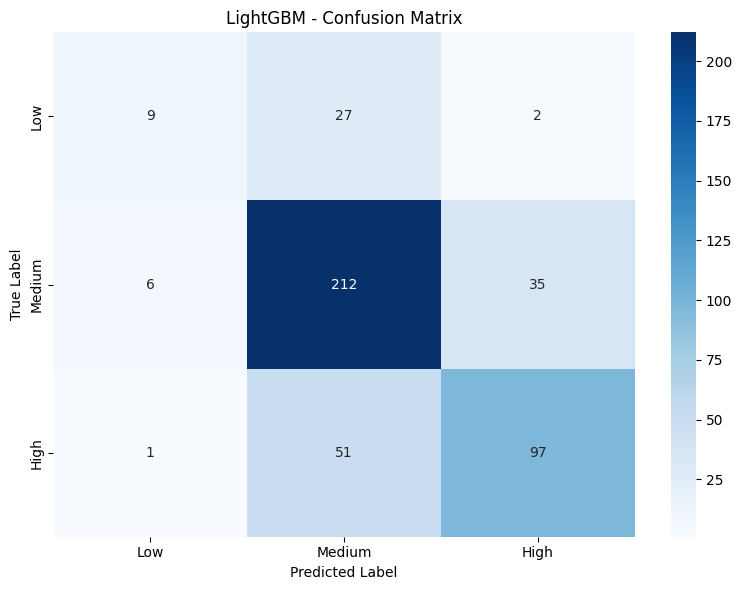


📊 XGBoost Results
Accuracy:  0.7364
F1-Score:  0.7248
Precision: 0.7320
Recall:    0.7364

Classification Report:
              precision    recall  f1-score   support

         Low       0.67      0.26      0.38        38
      Medium       0.74      0.84      0.79       253
        High       0.73      0.68      0.71       149

    accuracy                           0.74       440
   macro avg       0.71      0.60      0.62       440
weighted avg       0.73      0.74      0.72       440



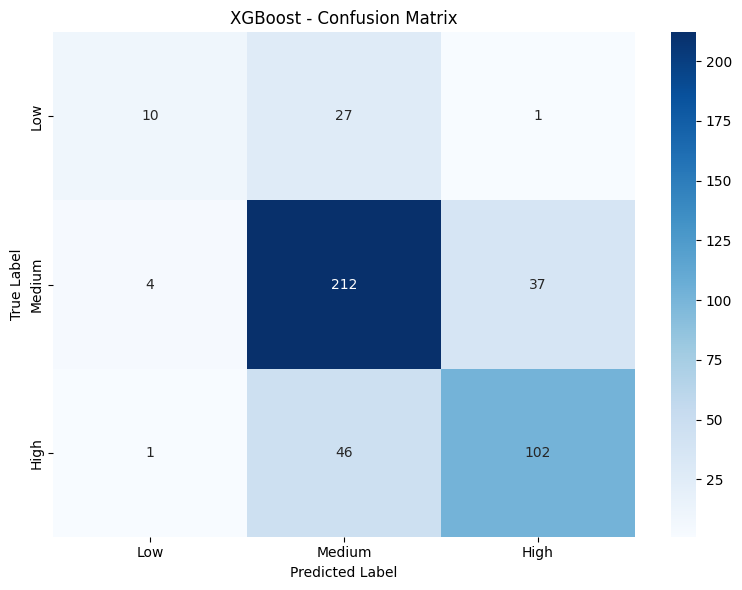


📊 Ensemble Results
Accuracy:  0.7295
F1-Score:  0.7176
Precision: 0.7236
Recall:    0.7295

Classification Report:
              precision    recall  f1-score   support

         Low       0.62      0.26      0.37        38
      Medium       0.74      0.84      0.79       253
        High       0.73      0.66      0.69       149

    accuracy                           0.73       440
   macro avg       0.70      0.59      0.62       440
weighted avg       0.72      0.73      0.72       440



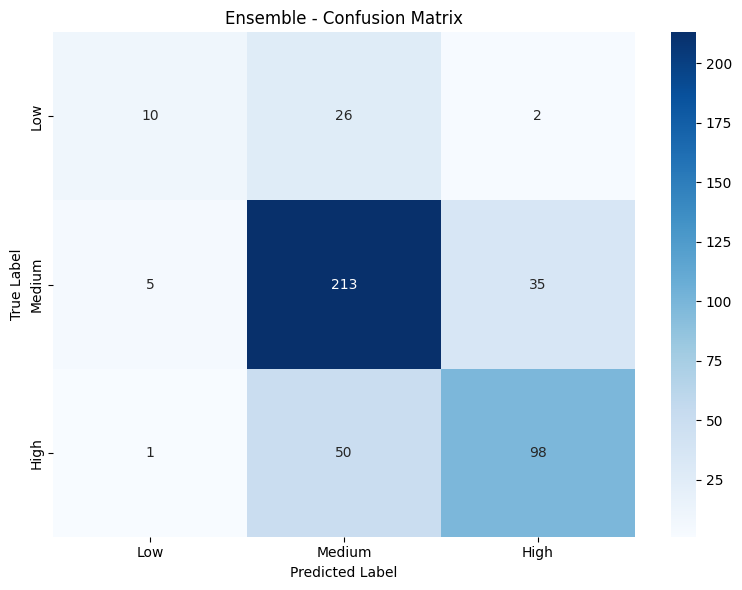


📊 FINAL COMPARISON
   Model  Accuracy  F1-Score  Precision   Recall
LightGBM  0.722727  0.709914   0.714057 0.722727
 XGBoost  0.736364  0.724787   0.732016 0.736364
Ensemble  0.729545  0.717631   0.723591 0.729545

🏆 BEST MODEL: XGBoost
   F1-Score: 0.7248


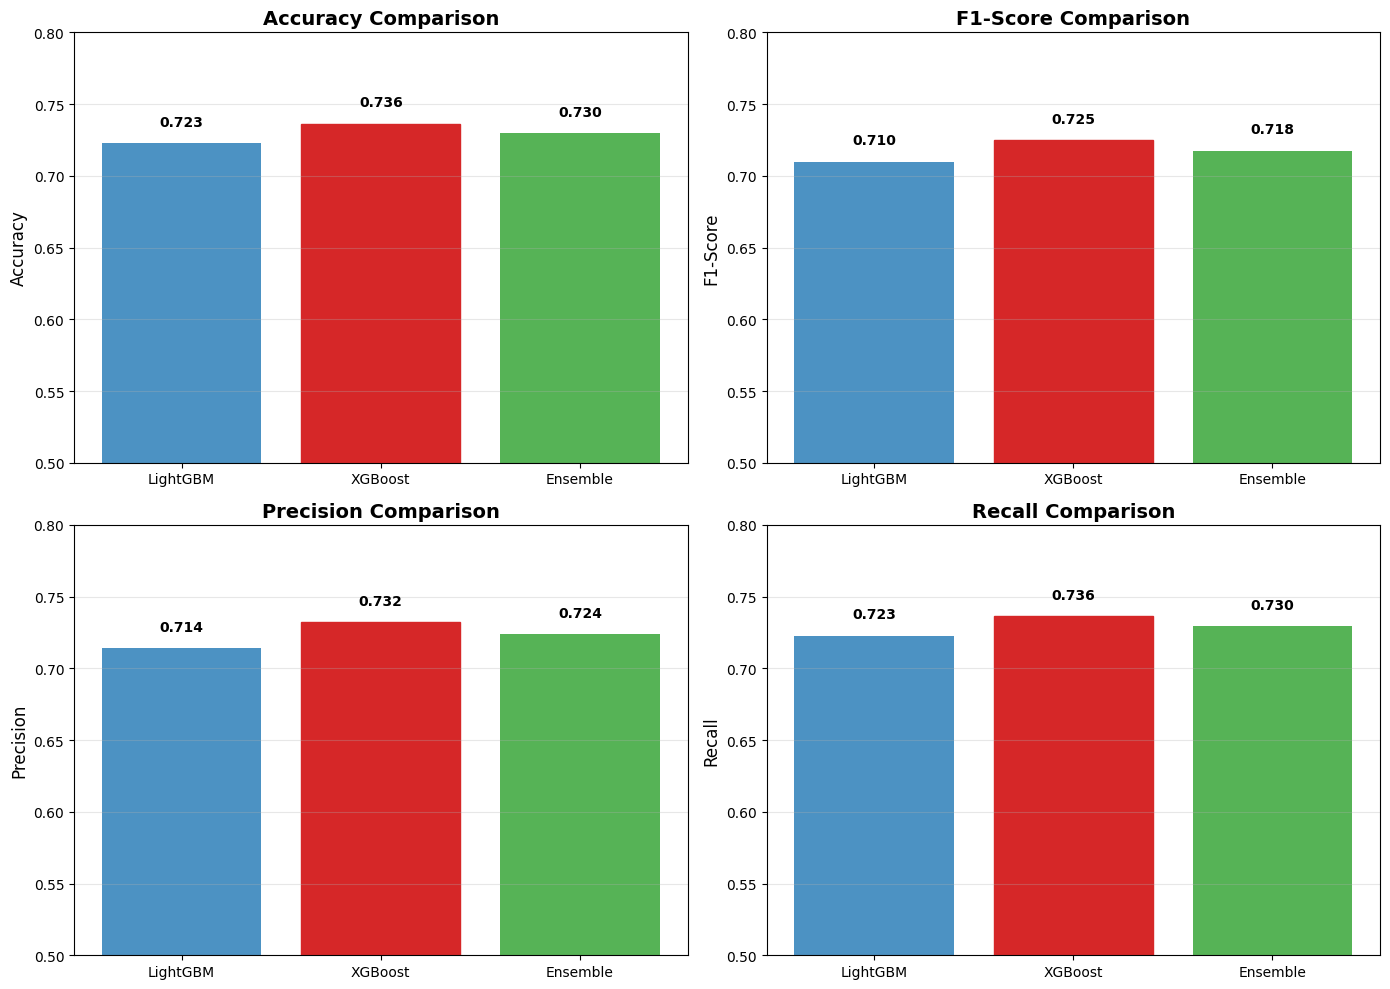

In [ ]:
from sklearn.ensemble import VotingClassifier

# ===========================
# 3. CREATE ENSEMBLE
# ===========================
print("\n" + "="*70)
print("STEP 3: Creating Ensemble (Soft Voting)")
print("="*70)

ensemble = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_best),
        ('xgb', xgb_best)
    ],
    voting='soft',  # Use probability averaging
    n_jobs=-1
)

ensemble.fit(X_train, y_train)
print("Ensemble model trained successfully!")


# ===========================
# 4. EVALUATE ALL MODELS
# ===========================
print("\n" + "="*70)
print("STEP 4: Model Performance Comparison")
print("="*70)

models = {
    'LightGBM': lgbm_best,
    'XGBoost': xgb_best,
    'Ensemble': ensemble
}

results = []
class_names = ['Low', 'Medium', 'High']

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1,
        'Precision': prec,
        'Recall': rec
    })
    
    print(f"\n{'='*70}")
    print(f"{name} Results")
    print(f"{'='*70}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Comparison table
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("📊 FINAL COMPARISON")
print("="*70)
print(results_df.to_string(index=False))

# Find best model
best_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_f1 = results_df.loc[best_idx, 'F1-Score']

print(f"\nBEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(results_df['Model'], results_df[metric], 
                  color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim([0.5, 0.8])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Highlight best
    best_bar_idx = results_df[metric].idxmax()
    bars[best_bar_idx].set_color('#d62728')
    bars[best_bar_idx].set_alpha(1.0)

plt.tight_layout()
plt.show()



STEP 5: Feature Importance Analysis

📈 Top 10 Most Important Features:
Feature  Average_Importance
    E10         1809.016503
     N5         1561.031202
     N7         1553.523837
     C2         1509.518331
     C9         1498.545580
     C8         1476.584431
     C4         1408.565882
     C5         1342.026306
     C1         1329.062424
     A8         1298.020266


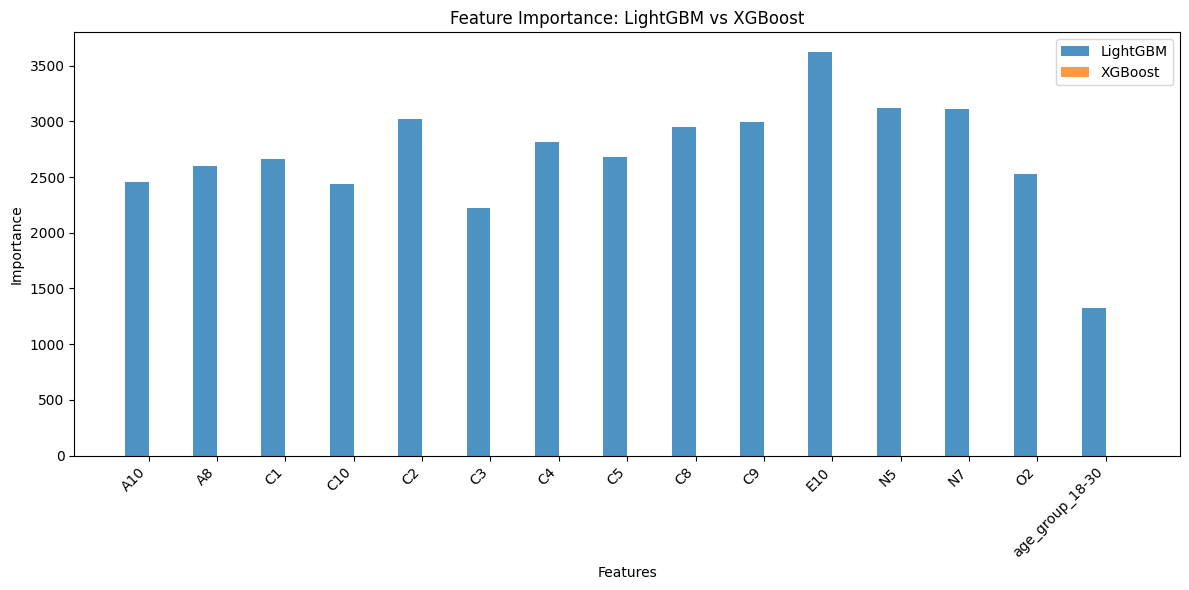

In [ ]:
# ===========================
# 5. FEATURE IMPORTANCE
# ===========================
print("\n" + "="*70)
print("STEP 5: Feature Importance Analysis")
print("="*70)

feature_names = X.columns.tolist()

# LightGBM importance
lgbm_importance = pd.DataFrame({
    'Feature': feature_names,
    'LightGBM_Importance': lgbm_best.feature_importances_
}).sort_values('LightGBM_Importance', ascending=False)

# XGBoost importance
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost_Importance': xgb_best.feature_importances_
}).sort_values('XGBoost_Importance', ascending=False)

# Merge and average
importance_combined = lgbm_importance.merge(xgb_importance, on='Feature')
importance_combined['Average_Importance'] = (
    importance_combined['LightGBM_Importance'] + 
    importance_combined['XGBoost_Importance']
) / 2
importance_combined = importance_combined.sort_values('Average_Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_combined.head(10)[['Feature', 'Average_Importance']].to_string(index=False))

# Plot combined importance
plt.figure(figsize=(12, 6))
x = np.arange(len(feature_names))
width = 0.35

plt.bar(x - width/2, importance_combined.sort_values('Feature')['LightGBM_Importance'], 
        width, label='LightGBM', alpha=0.8)
plt.bar(x + width/2, importance_combined.sort_values('Feature')['XGBoost_Importance'], 
        width, label='XGBoost', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance: LightGBM vs XGBoost')
plt.xticks(x, importance_combined.sort_values('Feature')['Feature'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


STEP 6: SHAP Analysis (Best Model)
✅ SHAP analysis complete (using 100 samples)


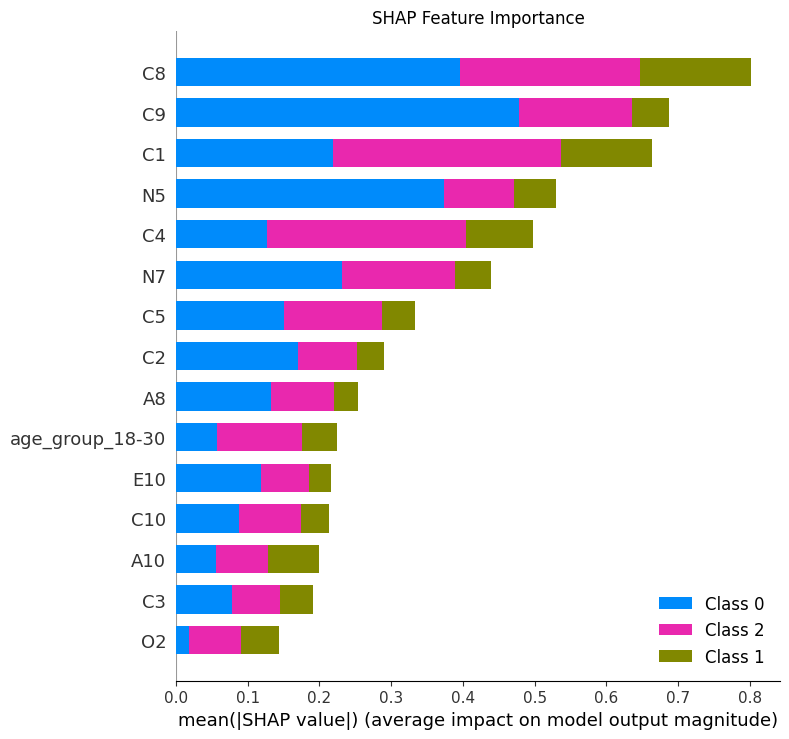

<Figure size 1000x800 with 0 Axes>

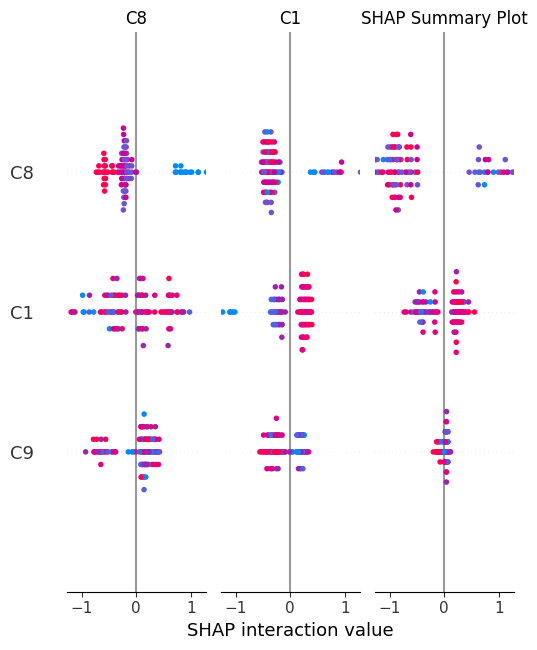

In [19]:
# ===========================
# 6. SHAP ANALYSIS
# ===========================
print("\n" + "="*70)
print("STEP 6: SHAP Analysis (Best Model)")
print("="*70)

best_model_for_shap = lgbm_best if best_model_name == 'LightGBM' else xgb_best
if best_model_name == 'Ensemble':
    best_model_for_shap = lgbm_best  # Use LightGBM for SHAP

explainer = shap.TreeExplainer(best_model_for_shap)
shap_sample_size = min(100, len(X_test))
X_test_sample = X_test.iloc[:shap_sample_size]
shap_values = explainer.shap_values(X_test_sample)

print(f"✅ SHAP analysis complete (using {shap_sample_size} samples)")

# Check if shap_values is a list (multiclass) or array
if isinstance(shap_values, list):
    # Multiclass - shap_values is a list of arrays
    for i, class_name in enumerate(class_names):
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[i], X_test_sample.values, 
                         feature_names=feature_names,
                         show=False, plot_type='bar')
        plt.title(f'SHAP Feature Importance - {class_name} Class')
        plt.tight_layout()
        plt.show()
    
    # Detailed SHAP for Medium class
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values[1], X_test_sample.values, 
                     feature_names=feature_names, show=False)
    plt.title('SHAP Summary - Medium Class (Most Common)')
    plt.tight_layout()
    plt.show()
else:
    # Binary or single array
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample.values, 
                     feature_names=feature_names,
                     show=False, plot_type='bar')
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample.values, 
                     feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()


In [20]:

# ===========================
# 7. SAVE MODELS
# ===========================
print("\n" + "="*70)
print("STEP 7: Saving Models")
print("="*70)

import pickle

with open("lgbm_model.pkl", "wb") as f:
    pickle.dump(lgbm_best, f)
print("✅ LightGBM model saved")

with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_best, f)
print("✅ XGBoost model saved")

with open("ensemble_model.pkl", "wb") as f:
    pickle.dump(ensemble, f)
print("✅ Ensemble model saved")



STEP 7: Saving Models
✅ LightGBM model saved
✅ XGBoost model saved
✅ Ensemble model saved


In [22]:
# ===========================
# 8. EXECUTIVE SUMMARY
# ===========================
print("\n" + "="*70)
print("📋 EXECUTIVE SUMMARY")
print("="*70)

print("\n🎯 OBJECTIVE:")
print("   Predict Grit levels (Low/Medium/High) from personality traits")
print("   Using ensemble of XGBoost + LightGBM classifiers")

print("\n📊 DATA:")
print(f"   • Total samples: {len(df)}")
print(f"   • Features: {len(feature_names)} personality traits")
print(f"   • Classes: 3 (Low: {(y==0).sum()}, Medium: {(y==1).sum()}, High: {(y==2).sum()})")
print(f"   • Train/Test split: {len(X_train)}/{len(X_test)}")

print("\n🔧 METHODOLOGY:")
print("   1. Binned continuous Grit scores into 3 classes")
print("   2. Optimized LightGBM with Optuna (30 trials)")
print("   3. Optimized XGBoost with Optuna (30 trials)")
print("   4. Created ensemble using soft voting")
print("   5. Evaluated on held-out test set")

print("\n📈 KEY RESULTS:")
for _, row in results_df.iterrows():
    print(f"\n   {row['Model']}:")
    print(f"      Accuracy:  {row['Accuracy']:.1%}")
    print(f"      F1-Score:  {row['F1-Score']:.1%}")
    print(f"      Precision: {row['Precision']:.1%}")
    print(f"      Recall:    {row['Recall']:.1%}")

print(f"\n🏆 BEST PERFORMER: {best_model_name} (F1: {best_f1:.1%})")

print("\n🔑 TOP 5 PREDICTIVE FEATURES:")
for i, row in importance_combined.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Average_Importance']:.3f}")

print("\n💡 INSIGHTS:")
improvement = (best_f1 - 0.72) * 100  # Compare to baseline
if improvement > 0:
    print(f"   • Ensemble improved F1-score by {improvement:.1f} percentage points")
else:
    print(f"   • Models plateaued around 73% - performance ceiling reached")
print(f"   • {importance_combined.iloc[0]['Feature']} is the strongest predictor")
print(f"   • Medium class is most common ({(y==1).sum()} samples)")

print("\n LIMITATIONS:")
print("   • Performance plateaus around 73% accuracy")
print("   • Limited to 15 features - eexploring with more features may help the accuracy, but may lead to overfitting. But especisally for the ensemble models, more features woudl be beneficial.")
print("   • Class imbalance may affect minority class predictions")
print("   • Cross-validation on small dataset may have high variance")

print("\n RECOMMENDATIONS:")
if best_f1 < 0.74:
    print("   • Consider using all 57 available features")
    print("   • Try feature engineering (interactions, polynomials)")
    print("   • Collect more data if possible")
    print("   • Consider if 73% is acceptable for this problem")
else:
    print("   • Model performance is strong - ready for deployment")
    print("   • Monitor performance on new data")
    print("   • Consider periodic retraining")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE!")
print("="*70)


📋 EXECUTIVE SUMMARY

🎯 OBJECTIVE:
   Predict Grit levels (Low/Medium/High) from personality traits
   Using ensemble of XGBoost + LightGBM classifiers

📊 DATA:
   • Total samples: 2200
   • Features: 15 personality traits
   • Classes: 3 (Low: 192, Medium: 1265, High: 743)
   • Train/Test split: 1760/440

🔧 METHODOLOGY:
   1. Binned continuous Grit scores into 3 classes
   2. Optimized LightGBM with Optuna (30 trials)
   3. Optimized XGBoost with Optuna (30 trials)
   4. Created ensemble using soft voting
   5. Evaluated on held-out test set

📈 KEY RESULTS:

   LightGBM:
      Accuracy:  72.3%
      F1-Score:  71.0%
      Precision: 71.4%
      Recall:    72.3%

   XGBoost:
      Accuracy:  73.6%
      F1-Score:  72.5%
      Precision: 73.2%
      Recall:    73.6%

   Ensemble:
      Accuracy:  73.0%
      F1-Score:  71.8%
      Precision: 72.4%
      Recall:    73.0%

🏆 BEST PERFORMER: XGBoost (F1: 72.5%)

🔑 TOP 5 PREDICTIVE FEATURES:
   1. E10: 1809.017
   2. N5: 1561.031
   3. N7: 